In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/dl/blob/master/rnns/rnns.ipynb)

# Recurrent Neural Networks

In feedforward neural networks activations flow only in one direction, from the input layer to the output layer. A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward. 

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/06022525/bptt.png)

The output of an RNN can be computed as follows

\begin{equation}
  y_t = f(\mathbf{W}_{xh}^T \mathbf{x}_t + \mathbf{b}_{xh} + \mathbf{W}_{hy}^T \mathbf{h}_{t-1} + \mathbf{b}_{hy})
\end{equation}

Where $\mathbf{W}_{xh}$ is the weight matrix that multiply the inputs to the network at step $t$ ($\mathbf{x}_t$) and $\mathbf{W}_{hy}$ is the weight matrix that multiply the *hidden state* at the previous step $t-1$ ($\mathbf{h}_{t-1}$). In the simplest form of a recurrent network, $h_t = y_t$, where $y_t$ is the output of the network at step $t$, but this is not always the case. The hidden state can be seen as a form of *memory* that allows an RNN to remember patterns in short sequences. $\mathbf{b}_{xh}$ and $\mathbf{b}_{hy}$ are the corresponding biases and $f$ is the activation function.

## Types of RNNs

We have different types of RNNs depending on the configuration of the inputs and outputs.

![](https://i.stack.imgur.com/b4sus.jpg)

although from an implementation point of view, all RNNs are of many-to-many type, and then we just keep the required inputs and outputs.

## Training RNNs

We can train an RNN using regular backpropagation, the trick is to unroll the network through time.

![](https://s3.ap-south-1.amazonaws.com/techleer/191.png)


The final gradient is the sum of all the gradients over all time steps. The outputs used in the loss function will depend on the type of RNN used.



## Time Series Forecasting

Let's learn how to work with RNNs with one interesting application: Time Series Forecasting. A Time Series is a sequence of data with one or more values per each time step. It can represent the number of active users in a website, the daily temperature of a city or a company's financial health. Time Series Forecasting is the task to predict future values of a time series given the historical data.

In [2]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

Here we generate a fixed number of time series and we will try to predict the last value based on all previous values.

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))




Normally, the input features are represented by 3D tensors of shape [*batch size (number of time series), number of time steps, number of features*].


Bad key "text.kerning_factor" on line 4 in
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


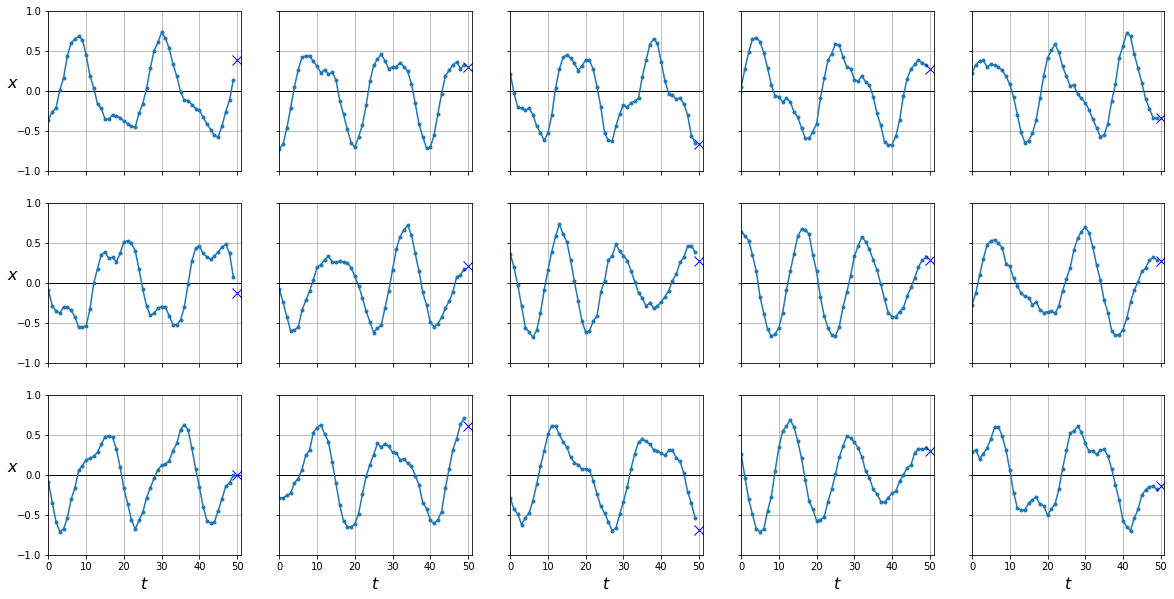

In [4]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

Our task consists of predicting the last value based on the previous ones.

### Naive Forecasting

One surprisingly good model for time series forecasting is to predict always the last value.

In [5]:
from sklearn.metrics import mean_squared_error

y_pred = X_valid[:,-1]
mean_squared_error(y_valid, y_pred)

0.020342829

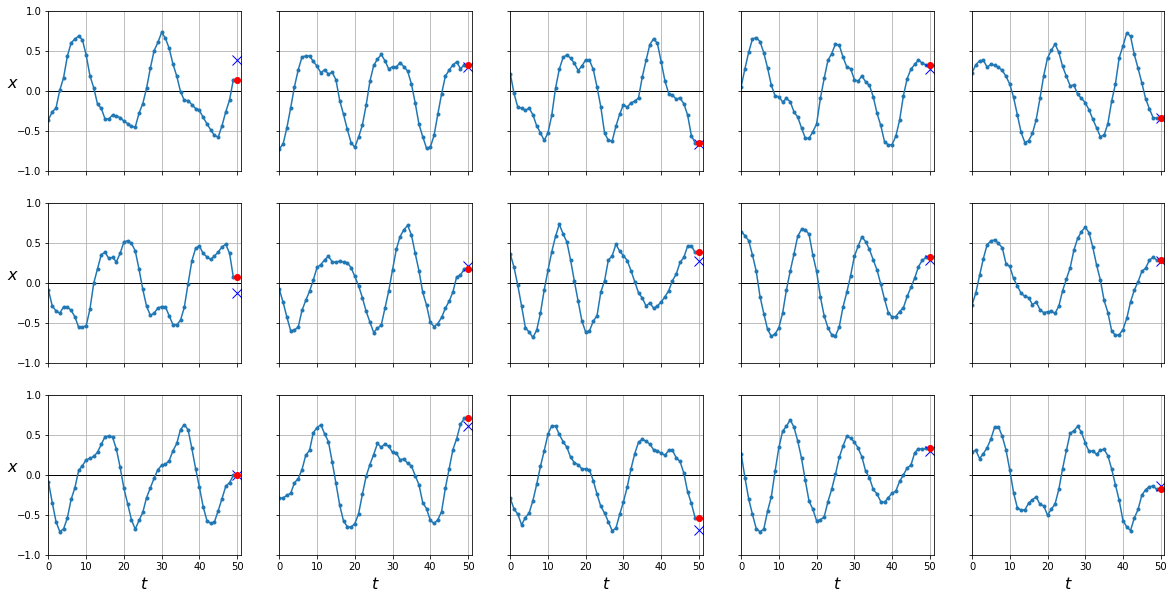

In [6]:
y_pred = X_test[:,-1]
plot_series(X_test, y_test, y_pred)

### Simple MLP

Using a simple fully connected Multilayer Perceptron can also work well, specially for very short sequences.

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [8]:
class SimpleMLP(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

mlp = SimpleMLP()

In [9]:
from src import Model

model = Model(mlp)

model.compile(optimizer = torch.optim.Adam(model.net.parameters(), lr=1e-3),
              loss = torch.nn.MSELoss())

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

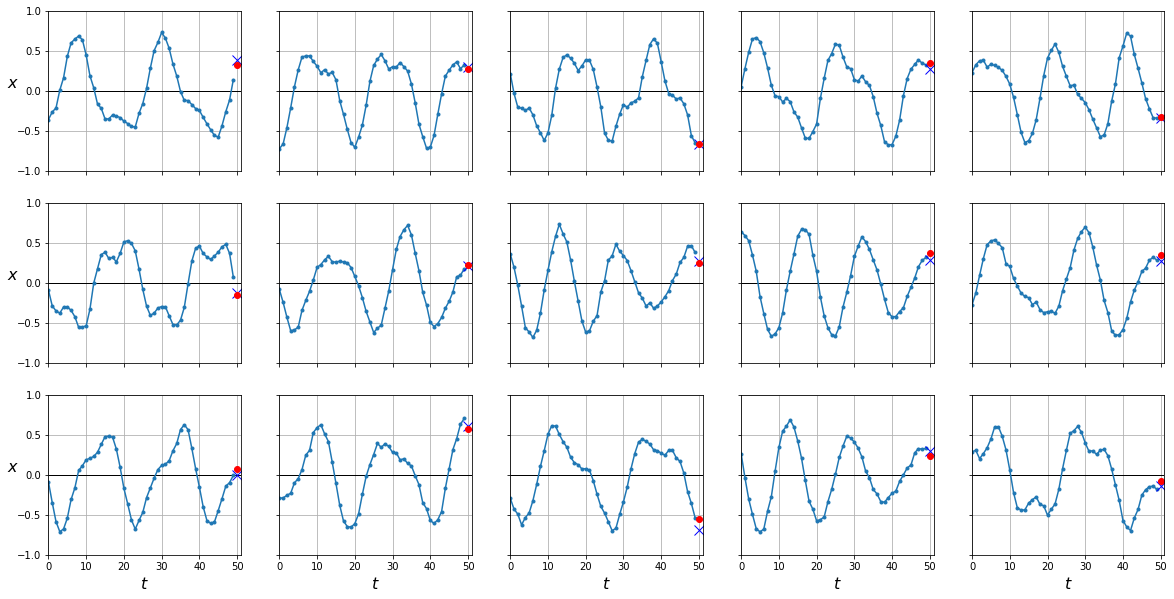

In [10]:
y_pred = model.predict(dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

In [11]:
mean_squared_error(y_test, y_pred.cpu())

0.0048158094

### A Simple RNN

Let's build a simple RNN with only one layer and a single neuron.

In [12]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x) 
    # return the last output
    return x[:,-1]

rnn = SimpleRNN()

In [13]:
model = Model(rnn)

model.compile(optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3),
              loss = torch.nn.MSELoss())

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

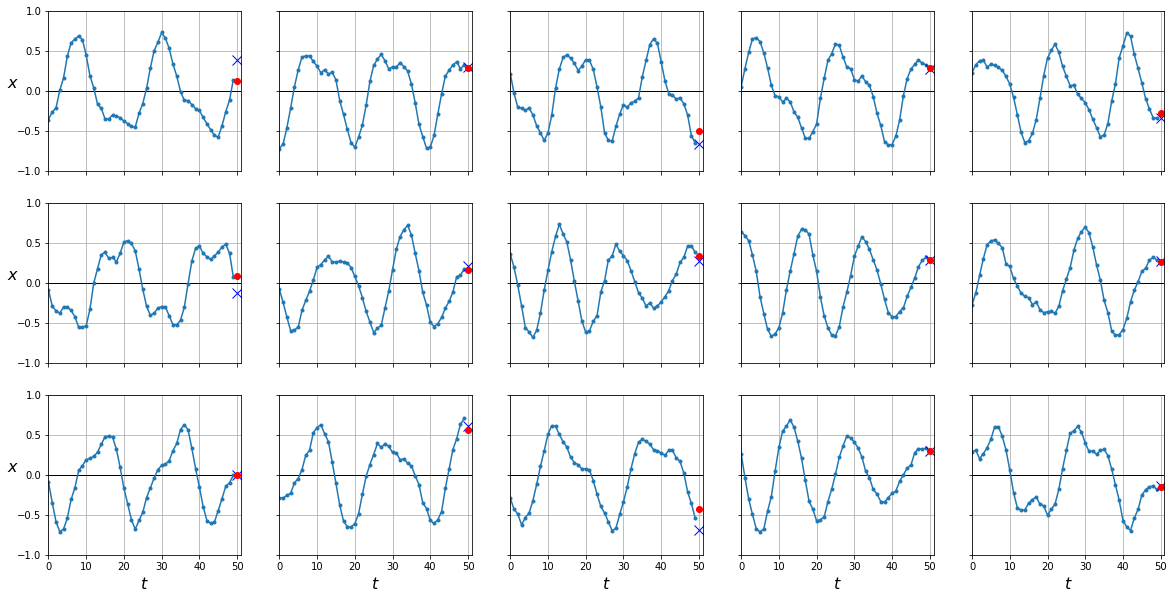

In [14]:
y_pred = model.predict(dataloader['test']).cpu().numpy()
plot_series(X_test, y_test, y_pred)

In [15]:
mean_squared_error(y_test, y_pred)

0.022532202

Why is the RNN giving worse results if it is supposed to work better with sequential data? 

In [16]:
# parameters in MLP

mlp.fc.weight.shape, mlp.fc.bias.shape

(torch.Size([1, 50]), torch.Size([1]))

In [17]:
# parameters in RNN

rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape

(torch.Size([1, 1]), torch.Size([1, 1]), torch.Size([1]), torch.Size([1]))

In the linear model we have one parameter for each input plus a bias term (51 in total). For an RNN with only one layer and one hidden unit we have 1 parameter for the input, another one for the hidden state and the bias terms (4 in total ... too simple!).

In [18]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [19]:
model = Model(rnn)

model.compile(optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3),
              loss = torch.nn.MSELoss())

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

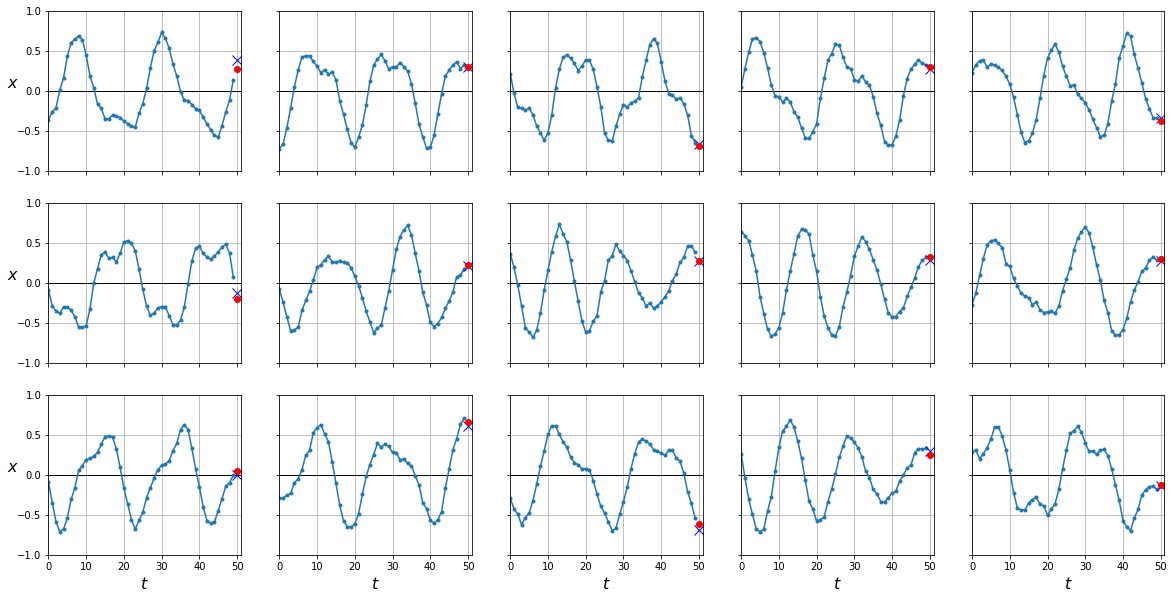

In [20]:
y_pred = model.predict(dataloader['test']).cpu().numpy()
plot_series(X_test, y_test, y_pred)

In [21]:
mean_squared_error(y_test, y_pred)

0.003371102

### Deep RNNs

We can stack multiple recurrent layers to build deep RNNs.

![](https://static.packt-cdn.com/products/9781787121089/graphics/image_06_008.png)




In [22]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.rnn1 = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn1(x) 
    # get the last output
    x = self.fc(x[:,-1])
    return x

In [23]:
model = Model(DeepRNN())

model.compile(optimizer = torch.optim.Adam(model.net.parameters(), lr=1e-3),
              loss = torch.nn.MSELoss())

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

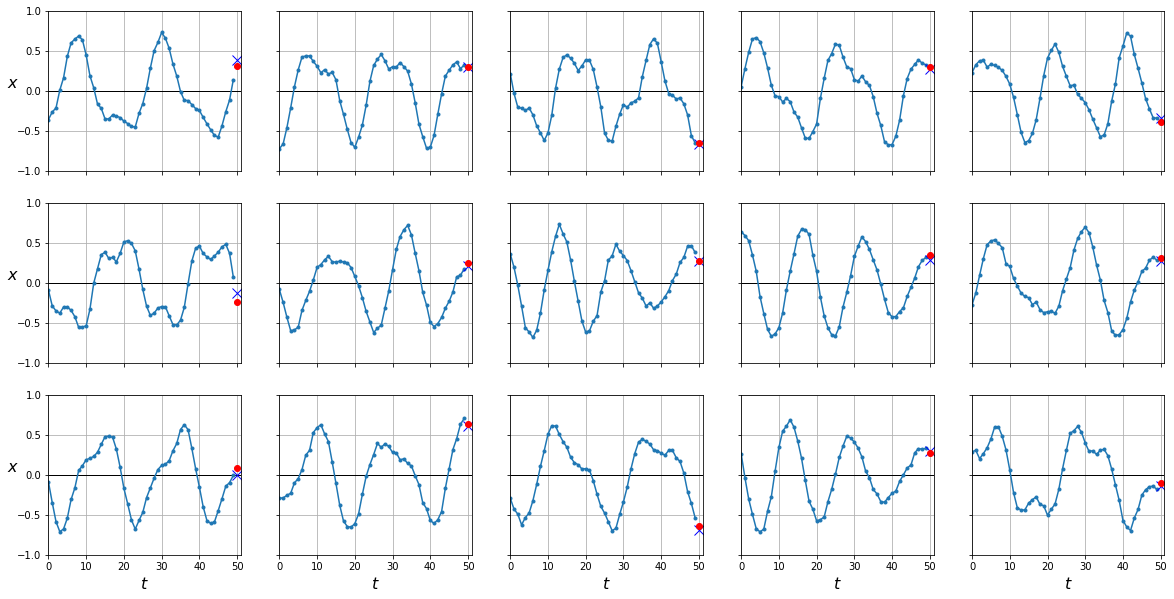

In [24]:
y_pred = model.predict(dataloader['test']).cpu().numpy()
plot_series(X_test, y_test, y_pred)

In [25]:
mean_squared_error(y_test, y_pred)

0.0034007349

## Forecasting several times ahead

Predicting only one value can be useful, but sometime it is prefered to predict several values in advance (a whole week, or month, or year). We can predict one step at a time, using the last prediction as the input for the new one. The problem is that error will propagate at each time step, resulting in poor predictions.





### Naive forecasting

In [35]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [27]:
y_pred = X_test[:,-1]
for step_ahead in range(9):
    y_pred = np.concatenate([y_pred, X_test[:,-1]], axis=1)

mean_squared_error(Y_test, y_pred)

0.262705

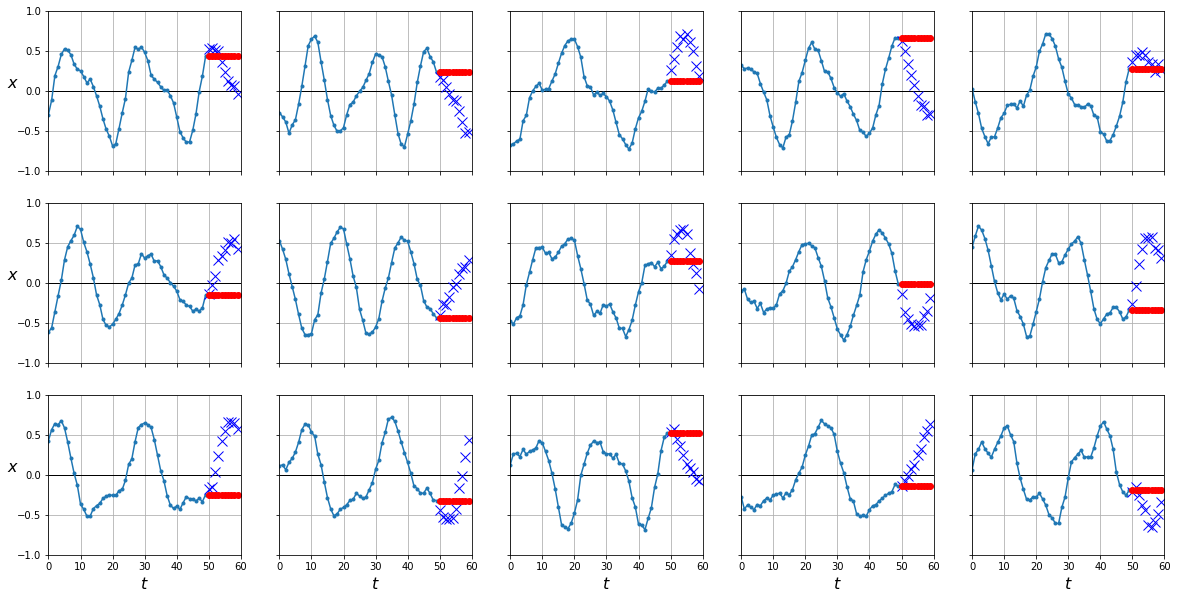

In [28]:
plot_series(X_test, Y_test, y_pred)

### Deep RNN

Using our last model we can predict values one by one

In [29]:
X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)
    y_pred_one = model.predict(inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]

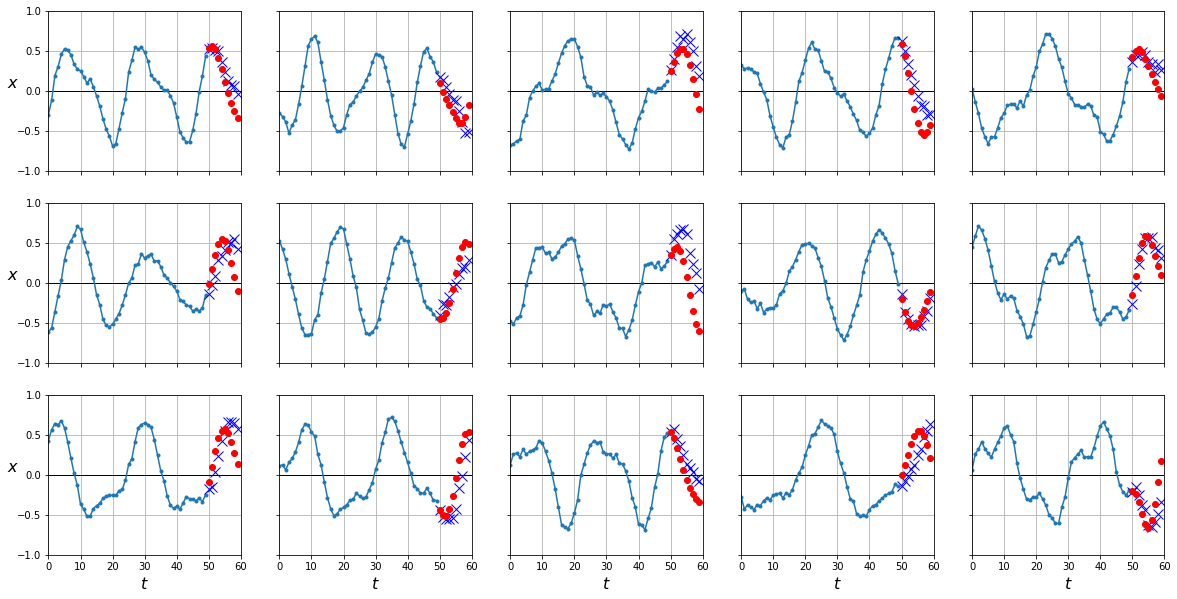

In [30]:
plot_series(X_test, Y_test, y_pred)

In [31]:
mean_squared_error(Y_test, y_pred)

0.051956035

Or train a new model to predict all new values at once.

In [36]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn1 = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn1(x) 
    x = self.fc(x[:,-1])
    return x

In [37]:
model = Model(DeepRNN())

model.compile(optimizer = torch.optim.Adam(model.net.parameters(), lr=1e-3),
              loss = torch.nn.MSELoss())

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

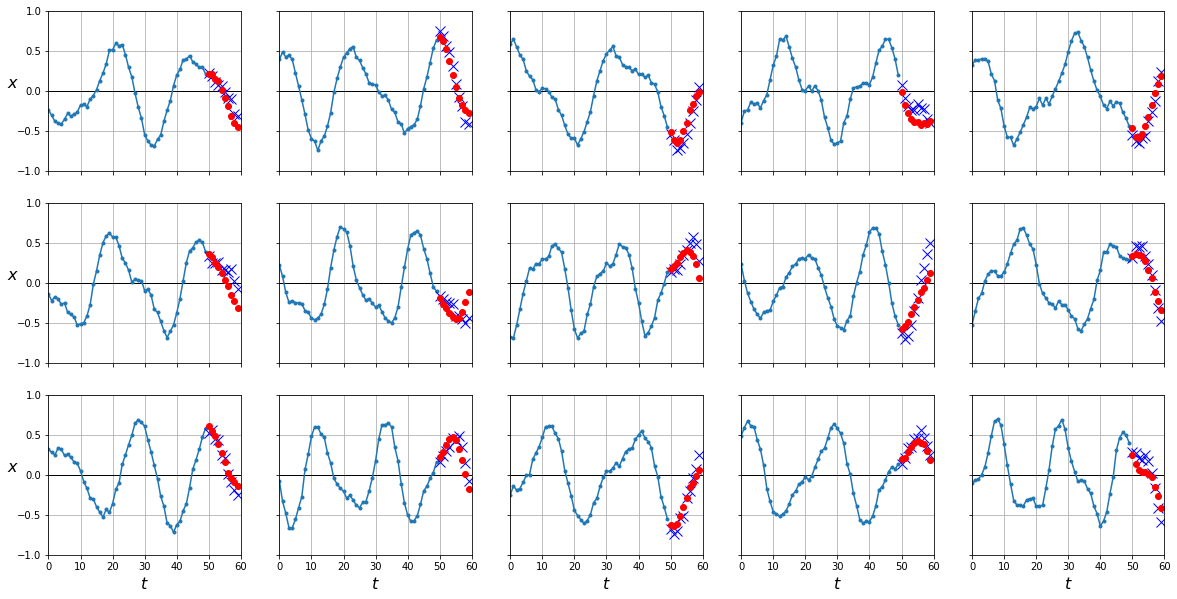

In [40]:
y_pred = model.predict(dataloader['test']).cpu().numpy()
plot_series(X_test, Y_test, y_pred)

In [41]:
mean_squared_error(Y_test, y_pred)

0.011771523

We can do better if instead of optimizing the network only for the last values, we train to optime the 10 next values for each time step. In order to keep a good track of the model's performance, we compute a metric only for the last predictions.

In [42]:
n_steps = 50
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [55]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn1 = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn1(x) 
    # reshape rnn output to feed fc
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # reset to original shape
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

class Metric():
  def __init__(self):
    self.name = "last_step_mse"
  
  def __call__(self, outputs, preds):
    return (outputs[:,-1] - preds[:,-1]).pow(2).mean().item()

In [47]:
model = Model(DeepRNN())

model.compile(optimizer = torch.optim.Adam(model.net.parameters()),
              loss = torch.nn.MSELoss(),
              metrics=[Metric()])

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

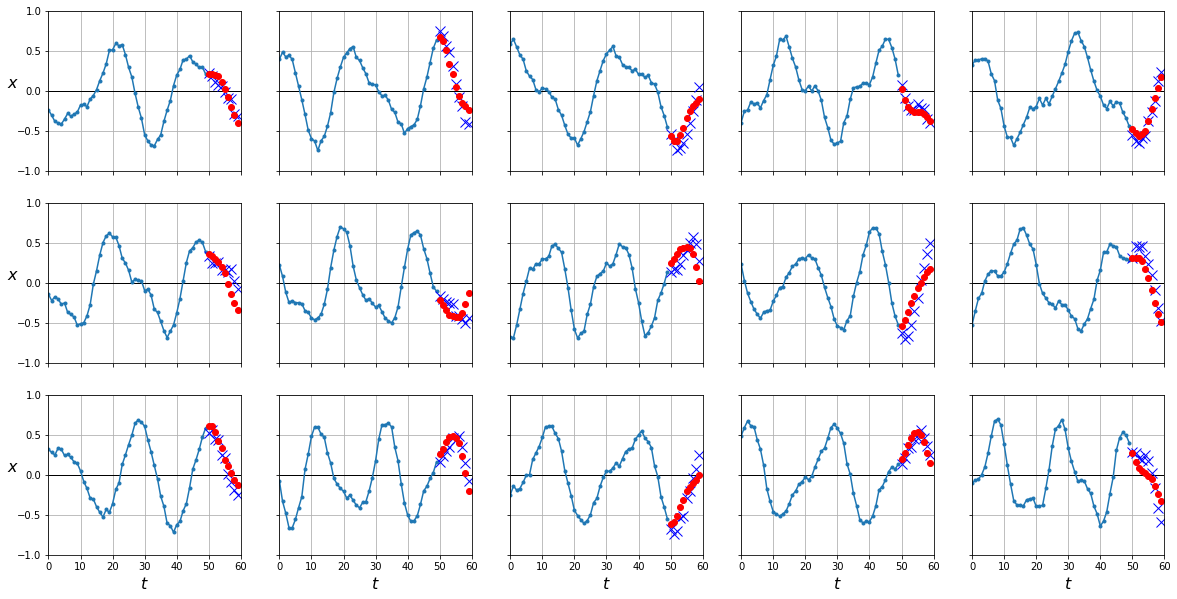

In [48]:
y_pred = model.predict(dataloader['test']).cpu().numpy()
plot_series(X_test, Y_test[:,-1], y_pred[:,-1])

In [49]:
mean_squared_error(Y_test[:,-1], y_pred[:,-1])

0.015259534

### Intervals of confidence

When forecasting time series it is often required to provide intervals of confidence. One technique that we can use is *MC Dropout* (Monte Carlo Dropout).

In [56]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn1 = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn1(x) 
    # reshape rnn output to feed fc
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # reset to original shape
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [57]:
model = Model(DeepRNN(dropout=0.3))

model.compile(optimizer = torch.optim.Adam(model.net.parameters()),
              loss = torch.nn.MSELoss(),
              metrics=[Metric()])

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

In [59]:
# be careful with this ! If you have Batch Norm (or other layers that behave differently in train/eval mode, set to train only the dropout layers!

y_preds = np.stack([model.predict(dataloader['test'], train=True).cpu().numpy() for sample in range(100)])
y_pred = y_preds.mean(axis=0)
y_pred_std = y_preds.std(axis=0)

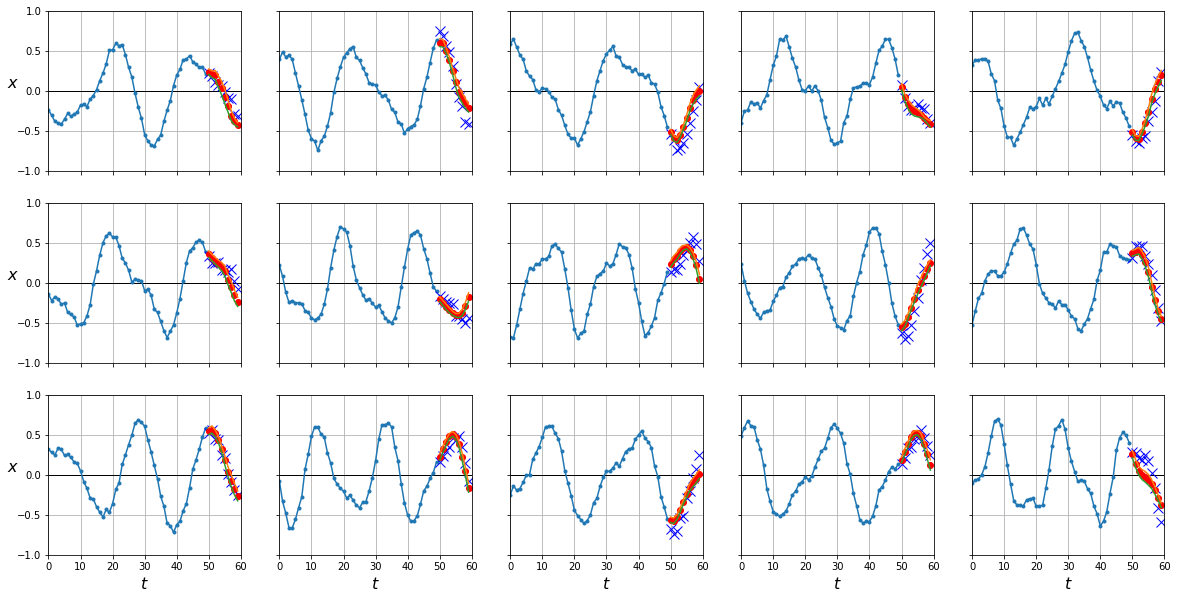

In [60]:
plot_series(X_test, Y_test[:,-1], y_pred[:,-1], y_pred_std[:, -1])

## LSTM

Simple RNNs work well with short sequence of data, but due to the transformations that data goes through when traversing the network, some information is lost at each time step. To alleviate this issue, various types of recurrent neurons with long-term memmory exist. One such example is the LSTM cell (*Long Short-Term Memmory*).

![](https://upload.wikimedia.org/wikipedia/commons/9/98/LSTM.png)



In [63]:
class LSTM(DeepRNN):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn1 = torch.nn.LSTM(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)

In [64]:
model = Model(LSTM())

model.compile(optimizer = torch.optim.Adam(model.net.parameters()),
              loss = torch.nn.MSELoss(),
              metrics=[Metric()])

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

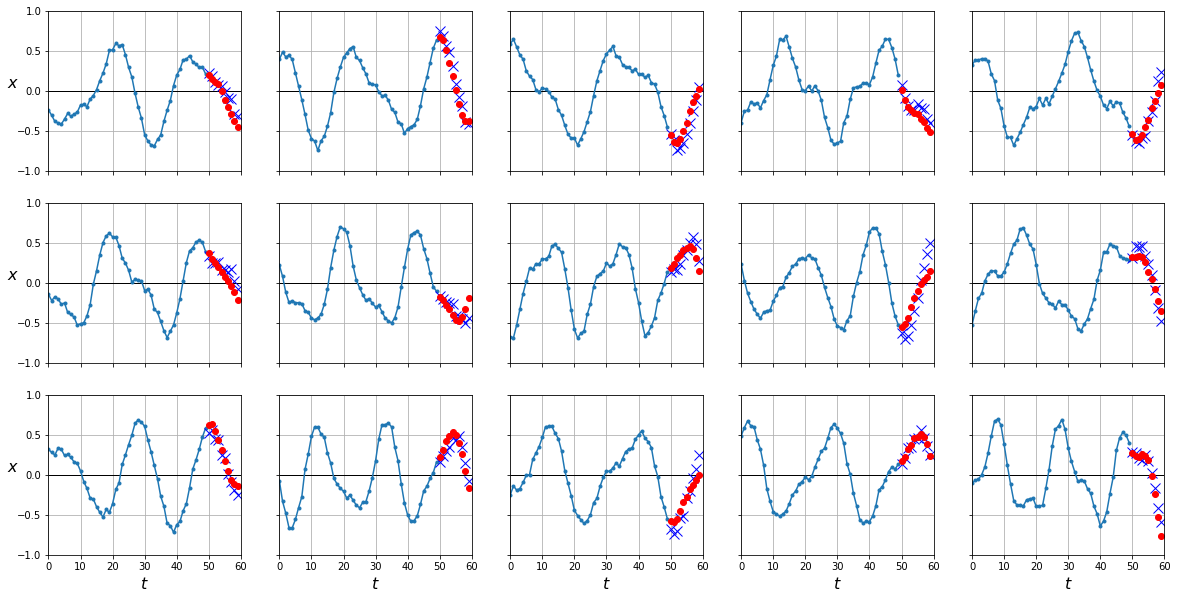

In [65]:
y_pred = model.predict(dataloader['test']).cpu().numpy()
plot_series(X_test, Y_test[:,-1], y_pred[:,-1])

In [66]:
mean_squared_error(Y_test[:,-1], y_pred[:,-1])

0.00886919

## GRU

Another popular choice for building RNNs is to use *Gated Recurrent Units* (GRU). They are a simplified version of LSTMs that can perform just as well.

![](https://feature.engineering/content/images/2016/03/gru.png)

In [68]:
class GRU(DeepRNN):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn1 = torch.nn.GRU(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)

In [69]:
model = Model(GRU())

model.compile(optimizer = torch.optim.Adam(model.net.parameters()),
              loss = torch.nn.MSELoss(),
              metrics=[Metric()])

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

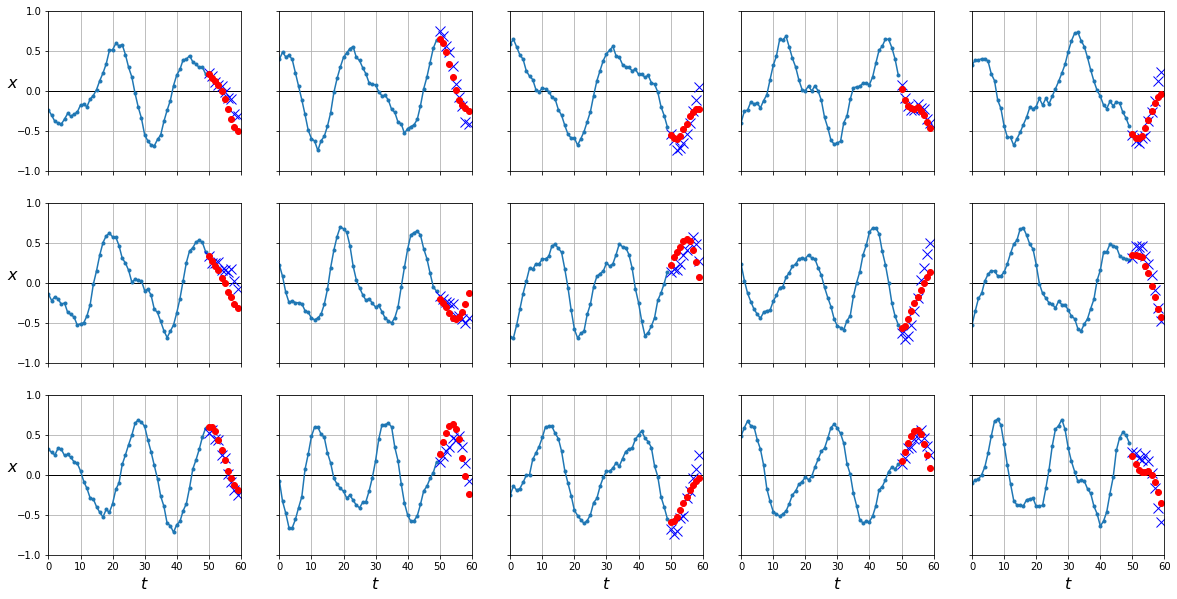

In [70]:
y_pred = model.predict(dataloader['test']).cpu().numpy()
plot_series(X_test, Y_test[:,-1], y_pred[:,-1])

In [71]:
mean_squared_error(Y_test[:,-1], y_pred[:,-1])

0.011655417

## Preview of Convolutions

We will see Convolutions in detail in future lectures, but for now just keep in mind that we can also use Convolutions to process sequence data, often getting better results.

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [83]:
class ConvRNN(torch.nn.Module):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.conv = torch.nn.Conv1d(1, 20, 4, stride=2, padding=0)
    self.rnn = torch.nn.GRU(input_size=20, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x = self.conv(x.permute(0,2,1))
    x, h = self.rnn(x.permute(0,2,1)) 
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [84]:
dataset = {
    'train': TimeSeriesDataset(X_train, Y_train[:,3::2]),
    'eval': TimeSeriesDataset(X_valid, Y_valid[:,3::2]),
    'test': TimeSeriesDataset(X_test, Y_test[:,3::2], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

model = Model(ConvRNN())

model.compile(optimizer = torch.optim.Adam(model.net.parameters()),
              loss = torch.nn.MSELoss(),
              metrics=[Metric()])

hist = model.fit(dataloader['train'], epochs=20, eval_dataloader=dataloader['eval'])

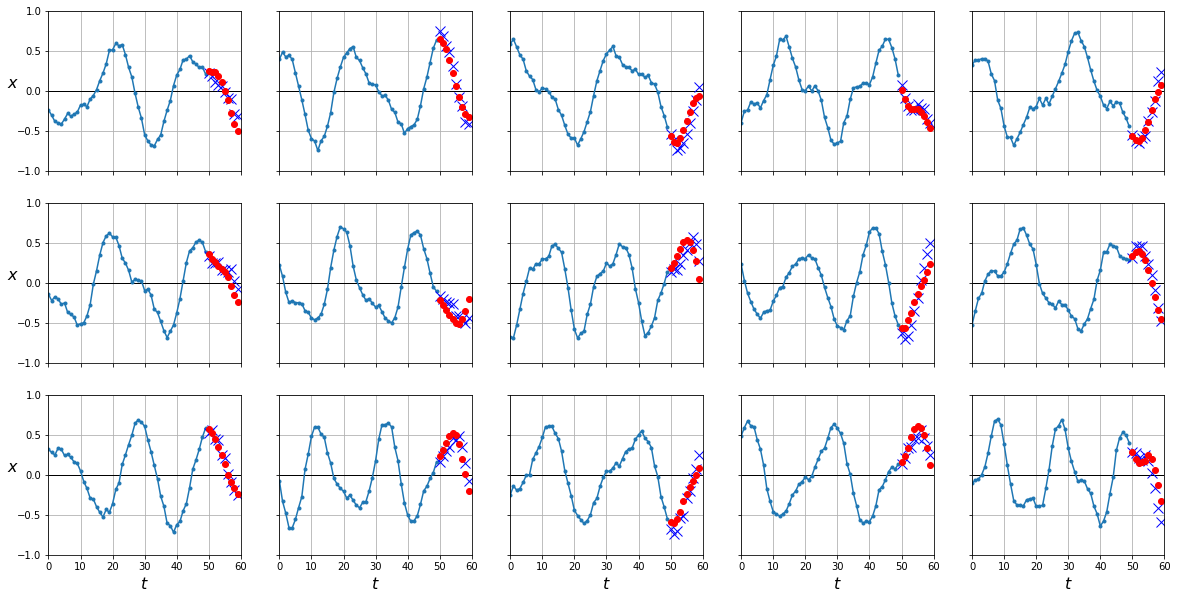

In [85]:
y_pred = model.predict(dataloader['test']).cpu().numpy()
plot_series(X_test, Y_test[:,-1], y_pred[:,-1])

In [86]:
mean_squared_error(Y_test[:,-1], y_pred[:,-1])

0.009064945